# The Maximum Distance Problem and Minimum Spanning Trees

### Computational exploration (See [arXiv paper](https://arxiv.org/abs/2004.07323) for details)

Given a compact $E\subset \mathbb{R}^n$ and $s > 0$, the maximum distance problem (MDP) asks to find a compact and connected subset of $\mathbb{R}^n$ of smallest one dimensional Hausdorff measure, whose $s$-neighborhood covers $E$. For $E\subset \mathbb{R}^2$, we prove that minimizing over minimal spanning trees (MSTs) that connect the centers of balls of radius $s$, which cover $E$, solves the MDP. 

In this notebook, you can computationally explore instances of MDP, and try to solve them by forming MSTs. You select the domain $E \subset \mathbb{R}^2$ (in the unit square, to be precise), which is supposed to be a closed, bounded set with possible disjoint holes. You then select vertices for the MST. For a given choice of $s$, the coverage of $E$ by the set (MST$+ s$-ball) is verified and displayed. You can then change the $s$, and/or pick a different set of vertices for the MST.


### Required packages

* [Shapely](https://pypi.org/project/Shapely/)
* [Descartes](https://pypi.org/project/descartes/)
* [Figures](https://pypi.org/project/Figures/) (see **note** below)
* matplotlib
* numpy
* scipy (for [distance computations](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html))

*One may have trouble getting Figures installed, so make sure you save the file **figures.py** (included in the repo with this file) in the current directory (or in a location where your Python looks for automatically). See  [this web page](https://github.com/Toblerity/Shapely/issues/536) for details of this error.*

In [1]:
from matplotlib import pyplot as plt

from shapely.geometry import Point, asPolygon, MultiPolygon, MultiLineString
from shapely.ops import unary_union
from descartes import PolygonPatch

from figures import SIZE, BLUE, RED, GRAY, set_limits, plot_coords, plot_line, color_isvalid

import numpy as np
from scipy.spatial.distance import pdist


#### Squareform index function and function to plot a set of lines

In [2]:
# Returns the index in the vector of all pairwise distances between
# n points for a given pair i,j. i < j is assumed.
# Will *NOT* work correctly for i==j ! 
def SqrfmIdx(n, i, j):
    return np.int(n*i + j - i*(i+1)/2 - i - 1)

def plot_lines(ax, ob):
    for line in ob:
        plot_line(ax, line, color=RED, alpha=0.7, zorder=2)

### Step 0: Create canvas of unit square, with grid

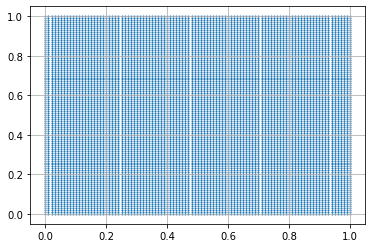

In [3]:
nX = 101
nY = 101
PtsX = np.linspace(0,1,nX)
PtsY = np.linspace(0,1,nY)
X, Y = np.meshgrid(PtsX, PtsY)

nPts = nX * nY
Xcol = X.reshape(nPts, 1)
Ycol = Y.reshape(nPts, 1)
GrdPts = np.concatenate( (Xcol, Ycol), axis=1)
GrdPts = np.around(GrdPts, 2) # round to two decimal point when using nX = nY = 101
D_GrdPts = pdist(GrdPts)


fig, ax = plt.subplots()

plt.scatter(X, Y, s=1)
plt.grid()

### Step 1: Select domain to be covered 

Click anywhere (using the mouse) inside the grid once to initialize, and then click the **sequence** of points that form the boundary of the domain $E$. The sequence could be clockwise (CW) or counterclockwise (CCW). A left click selects a point, a right click cancels the previous selection. Press *Enter* when done. The boundary is set as the collection of edges connecting consecutive points in the sequence (with the last point connecting to the first point).

Errors could result if the boundary loops on itself (i.e., crosses itself at a point). Either cancel selections of points going back to remove the loop, and re-select the boundary points. Or, rerun this Step.

Two **disjoint** holes could be carved out from inside the domain selected as above. Each hole is selected in the same way as selecting $\partial E$. The order of points could be CW or CCW, and could be different from the order chosen for selecting points of $\partial E$. You could reassign nHoles to a different number ($\geq 0$) to change the number of holes. One could also choose a hole *outside* the domain $E$ to void the inclusion of the hole, but it is better to set the nHoles variable correctly.

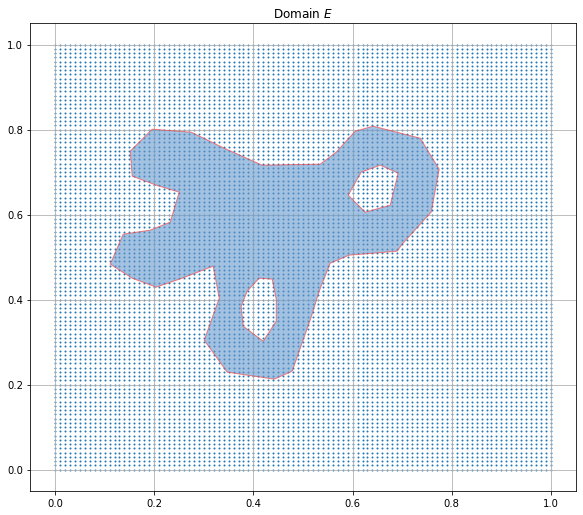

In [4]:
import matplotlib
matplotlib.use('TkAgg')

fig, ax = plt.subplots()

plt.scatter(X, Y, s=1)
plt.grid()

# Ask user to select boundary points of the polygon
plt.title("Click points in outer boundary of Domain; then press enter", fontsize=12)
plt.waitforbuttonpress()

Domainpts = plt.ginput(0,0)
Domain = asPolygon(Domainpts)

patch = PolygonPatch(Domain, fc=BLUE, ec=RED, alpha=0.7, zorder=2)
ax.add_patch(patch)

#plt.show() 

# Ask user to select boundary points of nHoles DISJOINT holes
nHoles = 2

for nH in np.arange(nHoles):
    plt.title("Click points of ONE hole inside Domain; then press enter", fontsize=12)
    plt.waitforbuttonpress()
    Holepts = plt.ginput(0,0)
    Hole = asPolygon(Holepts)
    Domain = Domain.difference(Hole)
    patch.remove()
    patch = PolygonPatch(Domain, fc=BLUE, ec=RED, alpha=0.6, zorder=3)
    ax.add_patch(patch)

plt.title("Domain $E$", fontsize=12)

plt.show() 

### Step 2: Select vertices for MST

The vertices are chosen from among the grid points, with points clicked by the user rounded to nearest grid points. Start by clicking anywhere inside the domain to initialize, and then select points by left clicks on the mouse. Right click cancels previous selection. Press *Enter* when done.

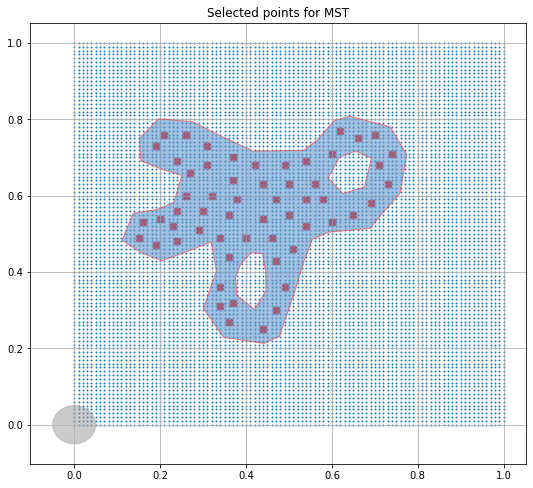

In [5]:
# repeat the plot functions from previous cell
fig, ax = plt.subplots()

plt.scatter(X, Y, s=1)
plt.grid()

patch2 = PolygonPatch(Domain, fc=BLUE, ec=RED, alpha=0.6, zorder=3)
ax.add_patch(patch2)

s = 0.05
sBall = Point(0,0).buffer(s)
sBallPatch = PolygonPatch(sBall, fc=GRAY, ec=GRAY, alpha=0.5, zorder=1)
ax.add_patch(sBallPatch)

plt.title('Select grid points for MST, then press enter. s = ' + str(s), fontsize=12)
plt.show()

plt.waitforbuttonpress()

MSTpts = plt.ginput(0,0)
MSTpts = np.around(MSTpts, 2)
n_MSTpts = len(MSTpts)

plt.scatter(MSTpts[:,0], MSTpts[:,1], s=50, c='r', marker='X')
plt.title("Selected points for MST", fontsize=12)
plt.show()

### Step 3: MST Computation

We construct the undirected graph $G = (V_G, E_G)$ with cost $C_G(E_G)$, and<br>
apply Kruskal's algorithm for MST that uses path optimality conditions.

*(Somewhat) naive implementation of Union-Find* <br>
Using an $n_G \times n_G$ matrix ($n_G=|V_G|$) to manipulate the connected components.

In [6]:
MSTIdx =  np.empty(n_MSTpts)
for i in np.arange(n_MSTpts):
    Idx = np.where((GrdPts[:,0]==MSTpts[i,0]) & (GrdPts[:,1]==MSTpts[i,1]))
    MSTIdx[i] = Idx[0][0]
    
MSTIdx = np.array(MSTIdx, dtype='int')
MSTIdx = np.sort(MSTIdx)

V_G = MSTIdx
E_G = [(MSTIdx[i],MSTIdx[j]) for i in range(n_MSTpts) for j in range(i+1, n_MSTpts)]
E_G = np.array(E_G)

n_G = len(V_G)
m_G = len(E_G)
#print(n_G,m_G)

C_G = np.zeros(m_G)
for i in range(m_G):
    C_G[i] = D_GrdPts[SqrfmIdx(nPts, E_G[i][0], E_G[i][1])]

IdxSrt_C_G = np.argsort(C_G)

MST = []
Label = np.arange(n_G)

Cpnts = np.zeros([n_G, n_G])-1;
for i in range(n_G):
    Cpnts[i,0] = i

for j in range(m_G):
    if len(MST) < n_G-1:
        I0 = np.where(V_G == E_G[IdxSrt_C_G[j]][0])
        I1 = np.where(V_G == E_G[IdxSrt_C_G[j]][1])
        i0 = I0[0][0]
        i1 = I1[0][0]
        if Label[i0] != Label[i1]:
            MST.append(j)
            if Label[i1] < Label[i0]: # swap i0 and i1
                tmp = i1
                i1 = i0
                i0 = tmp
            ci0 = np.where(Cpnts == i0)
            ci1 = np.where(Cpnts == i1)
            i0 = ci0[0][0]
            i1 = ci1[0][0]
            nz0 = np.where(Cpnts[i0,:] >= 0)
            nz1 = np.where(Cpnts[i1,:] >= 0)
            for k in np.arange(len(nz1[0])):
                Cpnts[i0,nz0[0][-1]+1+k] = Cpnts[i1,nz1[0][k]]
                Label[np.int(Cpnts[i1,nz1[0][k]])] = Label[i0]
                Cpnts[i1,nz1[0][k]] = -1

MSTLength = np.around(np.sum(C_G[IdxSrt_C_G[MST]]), 4)

### Step 4: Display Result MST + $s$-Ball over Domain

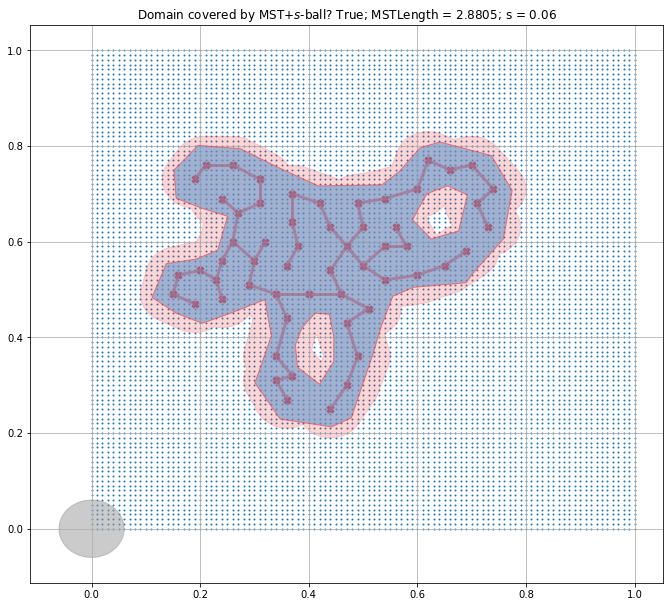

In [8]:
# repeat the plot functions from previous cells
fig, ax = plt.subplots()

plt.scatter(X, Y, s=1)
plt.grid()

patch2 = PolygonPatch(Domain, fc=BLUE, ec=RED, alpha=0.6, zorder=3)
ax.add_patch(patch2)

plt.scatter(MSTpts[:,0], MSTpts[:,1], s=50, c='r', marker='X')

s = 0.06 # s is initially set in Step 2
sBall = Point(0,0).buffer(s)
sBallPatch = PolygonPatch(sBall, fc=GRAY, ec=GRAY, alpha=0.5, zorder=1)
ax.add_patch(sBallPatch)



MSTedges = []
for i in np.arange(n_G-1):
    edge = E_G[IdxSrt_C_G[MST[i]],:]
    MSTedge = MultiLineString([(GrdPts[edge[0], :], GrdPts[edge[1], :])]) 
    plot_lines(ax, MSTedge)
    MSTedges.append(MSTedge)
    
    
MSTEdgesPlussBall = [MultiLineString([(GrdPts[E_G[IdxSrt_C_G[MST[i]],:][0], :], GrdPts[E_G[IdxSrt_C_G[MST[i]],:][1], :])]).buffer(s)  for i in np.arange(n_G-1) ]
UnionMSTEdgesPlussBall = unary_union(MSTEdgesPlussBall)
MSTEdgesPlusBallpatch = PolygonPatch(UnionMSTEdgesPlussBall, fc=RED, ec=RED, alpha=0.2, zorder=1)
ax.add_patch(MSTEdgesPlusBallpatch)

Intsctn = Domain.intersection(UnionMSTEdgesPlussBall)
CoveredOrNot = Domain.equals(Intsctn)

if CoveredOrNot==True:
    plt.title('Domain covered by MST$+s$-ball? ' + str(CoveredOrNot) + '; MSTLength = ' + str(MSTLength) + '; s = ' + str(s), fontsize=12)
else:
    plt.title('Domain covered by MST$+s$-ball with s = ' + str(s) + '? ' + str(CoveredOrNot), fontsize=12)
plt.waitforbuttonpress()
plt.show()



### Further steps and modifications

* To try a different $s$ with the same MST, update $s$ and rerun **Step 4**.
* To select a different set of vertices for the MST to cover the same domain, rerun **Step 2**.
* To start with a different domain, rerun **Step 1**.